In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

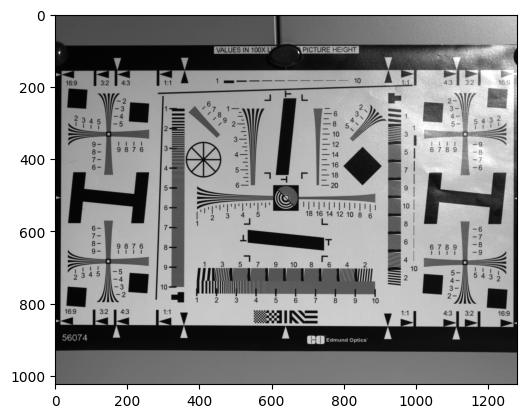

In [2]:
file = '01.bmp'
image = plt.imread(file)
plt.imshow(image, cmap = 'gray')
plt.show()


In [53]:
ROI_coords = cv2.selectROI(image)
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]

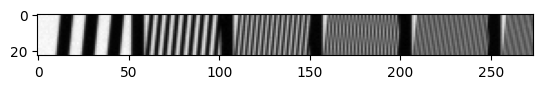

In [54]:
plt.imshow(ROI, cmap = 'gray')
plt.show()

In [55]:
## get line scan -- average line scan of the image -- only works if ROI selected is not slanted

ROI_SFR = ROI.mean(axis = 0)
ROI_LSF = np.abs(np.diff(ROI_SFR))

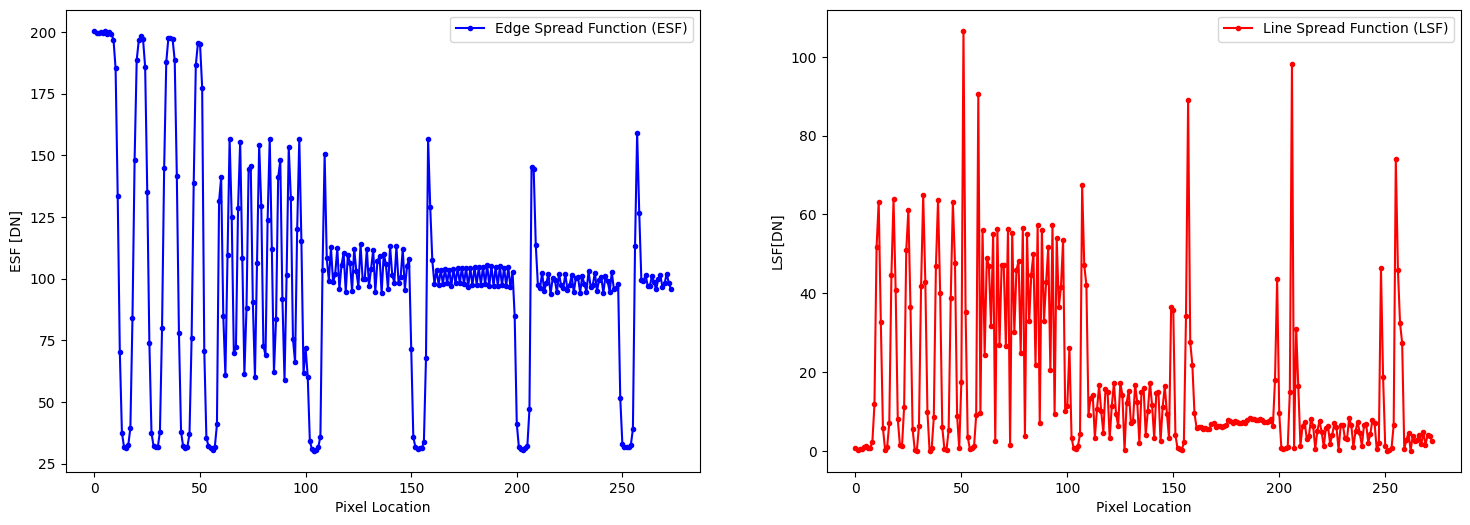

In [56]:
x_SFR = np.arange(0, len(ROI_SFR))
x_LSF = np.arange(0, len(ROI_LSF))

plt.figure(figsize = (9*2,6))
plt.subplot(121)
plt.plot(x_SFR, ROI_SFR, 'b.-', label='Edge Spread Function (ESF)')
plt.xlabel('Pixel Location')
plt.ylabel('ESF [DN]')
plt.legend()

plt.subplot(122)
plt.plot(x_LSF, ROI_LSF, 'r.-', label='Line Spread Function (LSF)')
plt.xlabel('Pixel Location')
plt.ylabel('LSF[DN]')
plt.legend()

plt.show()

In [57]:
ROI_MTF = np.abs(np.fft.fft(ROI_LSF))
ROI_MTF = ROI_MTF[:]/np.max(ROI_MTF)
ROI_MTF = ROI_MTF[:len(ROI_MTF)//2]

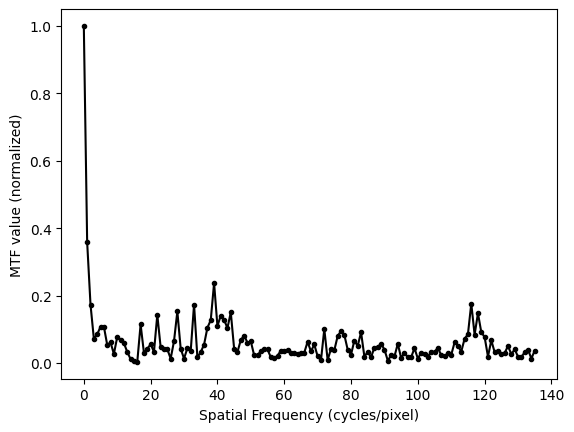

In [58]:
x_MTF= np.arange(0, len(ROI_MTF))

plt.plot(x_MTF, ROI_MTF, 'k.-', label='Modulation Transfer Functio (MTF)')
plt.xlabel('Spatial Frequency (cycles/pixel)')
plt.ylabel('MTF value (normalized)')
plt.show()
